In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly
import kaleido
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tools import add_constant

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from datetime import date
import glob

# customized modules

from src.data_models.stat_linear_regression import MyLR, get_SLR_analysis_results
from src.data_models.model_eval import MAPE, get_cv_results
from src.common_helpers.helpers import (
    select_k,
    get_k_fold_index_list,
    dict_to_dataframe,
)
from src.data_prepare.data_loader import load_data

# 0. Load data

In [3]:
Y_COL_NAME = "total_deposits_from_non-bank_customer"

In [4]:
## Load original dataframe

file_names = sorted(glob.glob("analyze-dataset/merged_data_*.csv"))

original_filename = file_names[-1]

# to avoid data leakage!
insample_df, outsample_df, _ = load_data(original_filename, insample_end_year=2017)

print("insample: ", insample_df.shape)
print("outsample: ", outsample_df.shape)

insample:  (104, 25)
outsample:  (14, 25)


# 1. Linear Model

## 1.1 Simple Linear Model

In [5]:
SLR_df = insample_df.copy()

# display(SLR_df.head())
print(SLR_df.shape)

(104, 25)


- For each single variable, build a simple linear regression model (excluding nan-value rows), collect corresponding metrics.

In [6]:
X = SLR_df.iloc[:, 2:].copy()

y = SLR_df[Y_COL_NAME].copy()

SLR_analysis_res_df = get_SLR_analysis_results(X, y)

print("================ SLR result ===================")
print(SLR_analysis_res_df.shape)

# SLR_analysis_res_df

================ SLR result ===================
(23, 12)


In [7]:
# create short name for each variable

X_to_alias_dict = {k: f"V_{i+1}" for (i, k) in enumerate(X.columns)}
alias_to_X_dict = {v: k for k, v in X_to_alias_dict.items()}

### Plot Bar chart of R-squared for simple linear regression  

The bar chart has shown that **Vxxx** has lowest R-squared metric for simple linear regression.   
Correspondingly, **Vxx** got relatively higher p-values.  

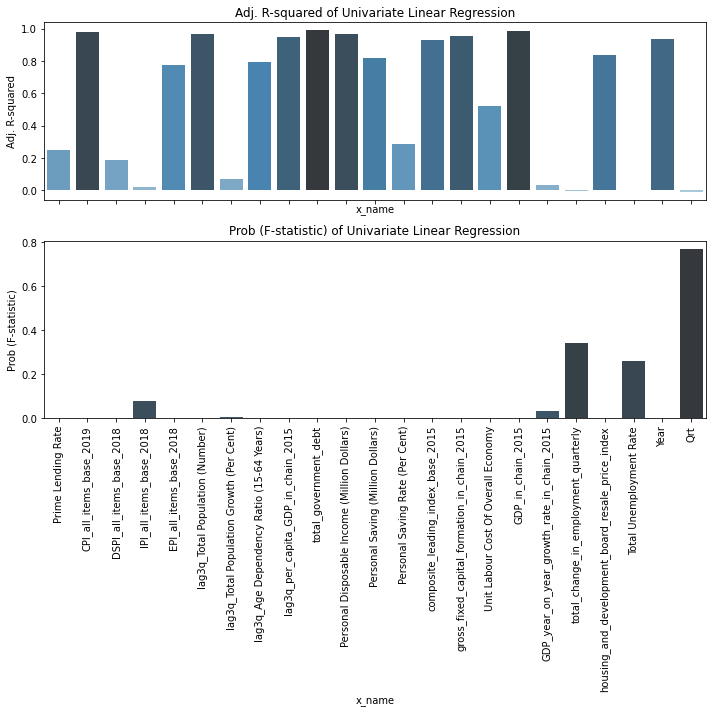

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1, ax2 = axs.flat
plt.xticks(rotation=90)


#### Plot adjusted R-squared ####

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = (
    SLR_analysis_res_df["Adj. R-squared"].argsort().argsort()
)  # http://stackoverflow.com/a/6266510/1628638

plot1 = sns.barplot(
    ax=ax1,
    x="x_name",
    y="Adj. R-squared",
    data=SLR_analysis_res_df,
    palette=np.array(pal)[rank],
)

ax1.set_title("Adj. R-squared of Univariate Linear Regression")

#### Plot p-values ####

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = (
    SLR_analysis_res_df["Prob (F-statistic)"].argsort().argsort()
)  # http://stackoverflow.com/a/6266510/1628638
# sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])

plot2 = sns.barplot(
    ax=ax2,
    x="x_name",
    y="Prob (F-statistic)",
    data=SLR_analysis_res_df,
    palette=np.array(pal)[rank],
)

ax2.set_title("Prob (F-statistic) of Univariate Linear Regression")

plt.tight_layout()
plt.savefig("./output/linear_model/univariate_LR.png")
plt.show()

## 1.2 Multiple Linear Model  

- [Cross Validation in Machine Learning using StatsModels and Sklearn with Logistic Regression Example](https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83)  
- [How to Selecting Predictors](https://otexts.com/fpp2/selecting-predictors.html)  
- [statsmodel wrapper for sklearn cross-validation](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)

In [9]:
MLR_df = insample_df.copy()

### 1.2.1 Multiple Linear Regression: all variables, feature importance measured by coefficient.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
normalized_MLR_df = min_max_scaler.fit_transform(MLR_df.iloc[:, 1:])

X = normalized_MLR_df[:, 1:]
y = normalized_MLR_df[:, 0]

## create alias for independent variables

sk_LR_model = LinearRegression()
# fit the model
sk_LR_model.fit(X, y)
# get importance
importance = sk_LR_model.coef_

importance

array([-0.03646634,  0.21459052, -0.00715494, -0.05937152,  0.1053393 ,
        0.27991367,  0.00426801, -0.10006228, -0.06797699,  0.39550621,
       -0.1688427 ,  0.09065722, -0.0269922 ,  0.20007753,  0.01388797,
        0.04289709,  0.44838706, -0.06301062,  0.00300049, -0.06814224,
        0.01377042, -0.29953115, -0.01084581])

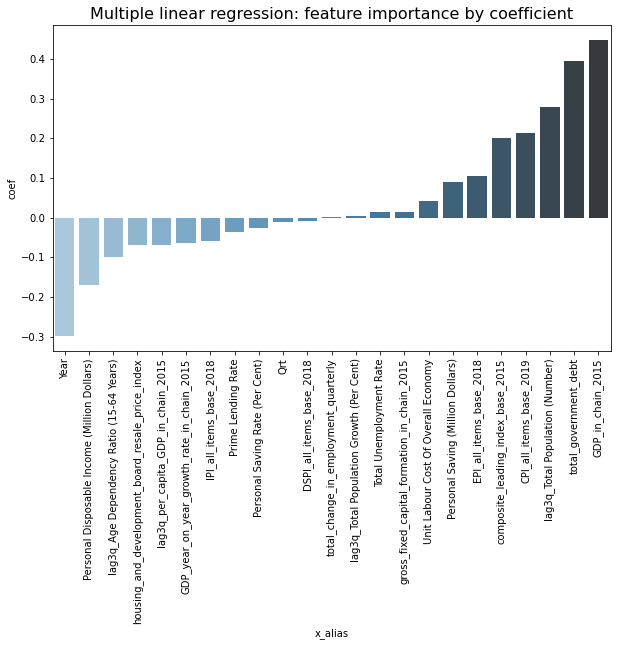

In [12]:
x_labels = MLR_df.columns[2:]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_alias", "coef"]


plt.figure(figsize=(10, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot2 = sns.barplot(
    x="x_alias",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_alias"],
)

plt.savefig("./output/linear_model/multivariate_LR_feature_importance")
plt.show()

### 1.2.2 Stepwise Regression: Backward elimination  

- [metrics string](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [13]:
from collections import defaultdict
import ast

In [14]:
#### test coe
y_name = Y_COL_NAME
x_names = list(MLR_df.columns[2:])

lr_model = LinearRegression()
res_dict = get_cv_results(lr_model, MLR_df, y_name, x_names)
res_df = dict_to_dataframe(res_dict)

res_df

,train_R2,test_R2,train_RMSE,test_RMSE,train_MPE,test_MPE,train_MAPE,test_MAPE
0,0.999097,0.998262,15778.642007,20823.650898,0.000465,0.000458,0.020749,0.027541


In [15]:
y_name = Y_COL_NAME
current_x_columns = list(MLR_df.columns[2:])
k = len(current_x_columns)
criteria_metric = "test_MAPE"

# record best model for k, k = 1,2,...,K
best_k_df_ls = []

# a linear regression model
lr_model = LinearRegression()

### add model using all variables first
print(
    f"============================ Feature Subset Size: {k} ================================="
)
# print(f"number of candidates: 1")
cv_eval_df = get_cv_results(lr_model, MLR_df, y_name, list(current_x_columns))
cv_eval_df["columns"] = str(list(current_x_columns))
cv_eval_df["subset_size"] = k
cv_eval_df["removed"] = "None"
best_k_df_ls.append(dict_to_dataframe(cv_eval_df))


# backwards elimination
while k > 1:

    print(
        f"============================ Feature Subset Size: {k-1} ================================="
    )
    current_x_combination = select_k(current_x_columns, k - 1)
    # print(list(current_x_combination)[0])

    ### get evaluation metrics for all combination of k subset
    temp_eval_ls = []
    for current_x in current_x_combination:

        cv_eval_df = get_cv_results(lr_model, MLR_df, y_name, list(current_x))

        cv_eval_df["columns"] = str(list(current_x))
        cv_eval_df["subset_size"] = k - 1

        # display(cv_eval_df)

        temp_eval_ls.append(dict_to_dataframe(cv_eval_df))

    # print(f"number of candidates: {len(temp_eval_ls)}")
    temp_eval_df = pd.concat(temp_eval_ls)

    # display(temp_eval_df)

    ### get the one with maximum metric value
    best_k_df = temp_eval_df[
        temp_eval_df[criteria_metric] == temp_eval_df[criteria_metric].max()
    ].copy()

    ##next round select from best k
    best_k_columns = ast.literal_eval(best_k_df["columns"].values[0])

    removed = [x for x in current_x_columns if x not in best_k_columns]
    best_k_df[
        "removed"
    ] = removed  # record what variable has been removed for current round

    best_k_df_ls.append(best_k_df)

    # print(removed)
    current_x_columns = best_k_columns

    k = k - 1


best_k_summary = pd.concat(best_k_df_ls).reset_index(drop=True)

display(best_k_summary)

============================ Feature Subset Size: 23 =================================
============================ Feature Subset Size: 22 =================================
============================ Feature Subset Size: 21 =================================
============================ Feature Subset Size: 20 =================================
============================ Feature Subset Size: 19 =================================
============================ Feature Subset Size: 18 =================================
============================ Feature Subset Size: 17 =================================
============================ Feature Subset Size: 16 =================================
============================ Feature Subset Size: 15 =================================
============================ Feature Subset Size: 14 =================================
============================ Feature Subset Size: 13 =================================
============================ Feature Subset

,train_R2,test_R2,train_RMSE,test_RMSE,train_MPE,test_MPE,train_MAPE,test_MAPE,columns,subset_size,removed
0,0.999097,0.998262,15778.642007,20823.650898,0.000465,0.000458,0.020749,0.027541,"['Prime Lending Rate', 'CPI_all_items_base_201...",23,None
1,0.998780,0.997892,18359.717480,23137.835114,0.000740,0.001280,0.024974,0.032248,"['Prime Lending Rate', 'CPI_all_items_base_201...",22,composite_leading_index_base_2015
2,0.998439,0.997107,20762.136515,27112.308882,0.000686,0.000771,0.028091,0.037274,"['Prime Lending Rate', 'CPI_all_items_base_201...",21,GDP_in_chain_2015
3,0.997376,0.995137,26923.857922,35110.811284,-0.000192,-0.000541,0.033683,0.044063,"['Prime Lending Rate', 'CPI_all_items_base_201...",20,total_government_debt
4,0.996498,0.994084,31111.088937,38978.137630,-0.000106,-0.001580,0.040984,0.050908,"['Prime Lending Rate', 'CPI_all_items_base_201...",19,EPI_all_items_base_2018
5,0.995994,0.992993,33276.090374,42351.683185,-0.000280,-0.001422,0.044738,0.056310,"['Prime Lending Rate', 'CPI_all_items_base_201...",18,gross_fixed_capital_formation_in_chain_2015
6,0.995139,0.992127,36668.012934,44924.281753,-0.000993,-0.003388,0.050632,0.062133,"['Prime Lending Rate', 'CPI_all_items_base_201...",17,IPI_all_items_base_2018
7,0.994445,0.990722,39205.840069,48877.710639,-0.002164,-0.004888,0.055176,0.068232,"['Prime Lending Rate', 'CPI_all_items_base_201...",16,Personal Disposable Income (Million Dollars)
8,0.990883,0.984091,50224.329124,63474.477065,-0.005249,-0.009108,0.069112,0.086557,"['Prime Lending Rate', 'DSPI_all_items_base_20...",15,CPI_all_items_base_2019
9,0.988859,0.980308,55486.801839,70115.379440,-0.007281,-0.010739,0.080420,0.102681,"['Prime Lending Rate', 'DSPI_all_items_base_20...",14,Personal Saving Rate (Per Cent)


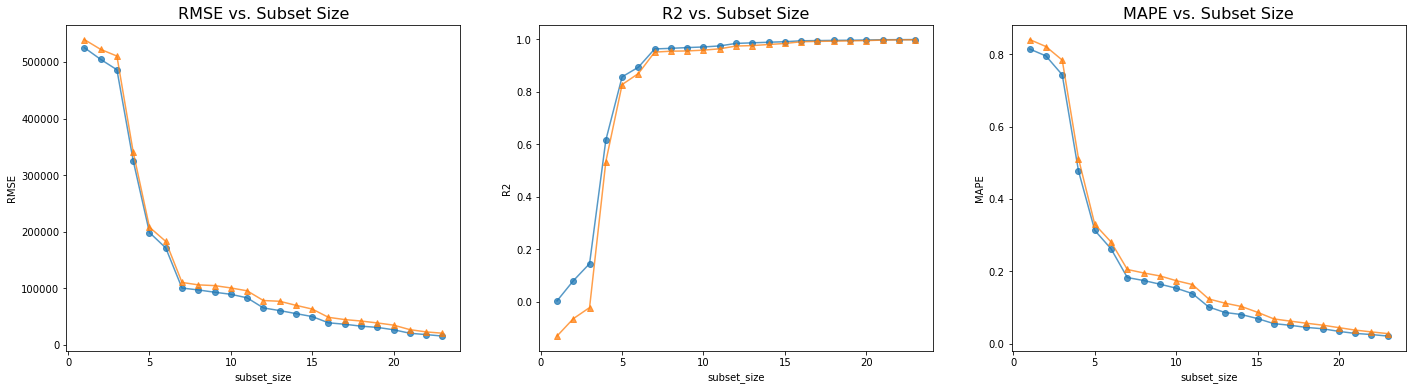

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
axs = axs.flat

train_ls = ["train_RMSE", "train_R2", "train_MAPE"]
test_ls = ["test_RMSE", "test_R2", "test_MAPE"]

for i in range(len(train_ls)):

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[train_ls[i]],
        marker="o",
        alpha=0.75,
    )

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[test_ls[i]],
        marker="^",
        alpha=0.75,
    )

    axs[i].set_xlabel("subset_size")
    axs[i].set_ylabel(train_ls[i].split("_")[-1])
    axs[i].set_title(f'{train_ls[i].split("_")[-1]} vs. Subset Size', fontsize=16)

plt.savefig("./output/linear_model/multivariate_LR_backwards_elimination.png")
plt.show()

### 1.2.3 Feature Selection by Model: Elasticnet

In [17]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNetCV

In [18]:
# define model
# model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
# evaluate model

# define model
ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

model = ElasticNetCV(l1_ratio=ratios, cv=cv)
# fit model
model.fit(X, y)
# summarize chosen configuration
print("alpha: %f" % model.alpha_)
print("l1_ratio_: %f" % model.l1_ratio_)

model.coef_

predict_y = model.predict(X)


MAPE(y, predict_y)

alpha: 0.000104
l1_ratio_: 1.000000


/opt/anaconda3/envs/maribank/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e-03, tolerance: 1.122e-03
  model = cd_fast.enet_coordinate_descent(


1243307475954.9172

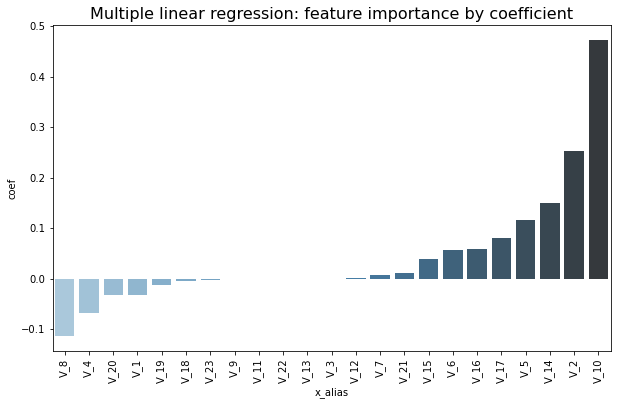

In [19]:
importance = model.coef_

x_labels = ["V_" + str(i + 1) for i in range(len(importance))]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_alias", "coef"]


plt.figure(figsize=(10, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot2 = sns.barplot(
    x="x_alias",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_alias"],
)

plt.savefig("./output/linear_model/multivariate_LR_feature_importance")
plt.show()